# Explanations:

- выборка - тензор из картинок, таргет - вектор силы

---

Авторы используют multi output GPR, настраивая гиперпараметры $\sigma_{cov}$ и $\sigma_{err}$ (можно однозначно их выразить через гиперпараметры из того же sklearn: $l$ и $\sigma$)

GPR - непараметрический метод, суть в том, что мы делаем предположение о виде матрицы корреляции признаков для известных данных.

---

Моделирование в хотя бы немного более сложном случае буду писать на Julia

---

Гиперпараметры:

1)k: Количество элементов в массивах r_cut и p для каждого атома

2)$r_{cut}(i)_j$, i=1..k, j=1..N: векторы r_cut для j атома тоже параметр

3)$p_(i)_j$, i=1..k, j=1..N: векторы p для j атома тоже параметр

4)N_neighbours for summation for IVs

В GPyTorch есть имплементация многоразмерного регрессора: https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/index.html#multi-output-vector-valued-functions

---

Пока что все размерности предполагаются в системе LJ, потому что пока пытаюсь это зафитить

Исходно пока в coords.csv и forces.csv находятся для 2 частиц данные

In [1]:
import random
import os
import time

from numba import jit, njit, vectorize
import numpy as np
import scipy
from numpy.linalg import norm as norm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
def set_seed(seed = 42):
    '''
    
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.

    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

---

# Hyperparameters:

In [3]:
class CFG:
    '''

    All hyperparameters are here

    '''

    N = 50     # число атомов
    K = 5     # можно называть это разрешением...чем число больше, тем больше размеры матрицы для атомов, фактически это число элементов в наборах p и r_cut

    L = L = 2 * N ** (1 / 3) # размер одной клетки при моделировании

    p = (np.random.rand(K) + 0.1).copy()
    r_cut = (np.random.rand(K) + 0.1).copy()

    N_neig= N - 1 if N != 2 else 1

    # train_bs = 8
    # val_bs = 16
    batch_size = 256

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    f_threshold = 10    # Если сила по какой-то координате превышает это значение, то строчка исключается, совсем маленьких по модулю сил быть не должно, если что при генерации просто r_cut поменьше надо делать
    coord_threshold = 2 * L     # Если вдруг очень большие расстояния, то надо выкидывать
    #
    output_size = 3     # Размерность аутпута модели

---

Имеется два .csv файла:

1)
| Id(time) | 1_x | 1_y | 1_z | ... | N_z |
|------|-----|-----|-----|-----|-----|
|      |     |     |     |     |     |
|      |     |     |     |     |     |
2)
| Id(time) | f_1_x | f_1_y | f_1_z | ... | f_N_z |
|------|-----|-----|-----|-----|-----|
|      |     |     |     |     |     |
|      |     |     |     |     |     |

Одна строчка отсюда превращается в N матриц (на каждый атом) с N векторами сил

В идеале сделать БДху из двух сущностей: сила и координата, где полями будут их проекции

In [4]:
def create_df_with_coords(coords_file_path = None, forces_file_path = None):
    '''
    just makes df from .csvs with coords and forces
    '''
    coords = pd.read_csv(coords_file_path)

    forces = pd.read_csv(forces_file_path)

    if CFG.N != int(coords.columns[-1][:-1]) + 1:
        raise Exception('Constant N is not equal to amount of particles in .csv')

    return pd.merge(left=coords, right=forces, on='t').drop('t', axis='columns')

In [5]:
a = set([1, 2])
b = set([2, 3])

a.union(b)

{1, 2, 3}

12 индекс - 1 отн 2

$$
\vec{r_1} = \vec{r_2} + \vec{r}_{12}
$$

$$
\vec{r}_{12} = \vec{r_1} - \vec{r}_{2}
$$

In [6]:
def _get_relative_positions(row, atom_number):
    '''
    This function processes one row of csv into something that we can work with

    Returns np.array matrix that consists of relative positions vectors for passed atom_number to every other atom
    and then we can chose only closest N_neighbours in the next functions
    
    row: df.iloc[row] - typeof(row): pd.Series
    
    returns: Rel_matrix, f_vec
    '''

    s_coord = pd.Series(dtype=float)
    other_atom_numbers = [i for i in range(CFG.N) if i != atom_number]

    for other_numb in other_atom_numbers:
        index = str(atom_number) + str(other_numb)
        for axis in ['x', 'y', 'z']:
            s_coord[index + axis] = row[str(atom_number) + axis] - row[str(other_numb) + axis]

    # we need force vector only for atom_number:
    force_vec = []
    for f_axis in ['f_x', 'f_y', 'f_z']:
        force_vec.append(row[str(atom_number) + f_axis])
        

    Rel_matrix = []
    cur_vector = []

    for (i, elem) in enumerate(s_coord.values):
        if i % 3 == 0 and i != 0:
            Rel_matrix.append(cur_vector)
            cur_vector = []

        cur_vector.append(elem)
    Rel_matrix.append(cur_vector)

    return np.array(Rel_matrix), np.array(force_vec)

In [7]:
from sklearn.preprocessing import normalize

In [8]:
@njit(fastmath=True)
def make_one_vec_transformed(vec, vec_norm, r_cut_i, p_i):
    '''
    vec: np.array - normalized vector
    norm: its norm
    r_cut_i: i-th component of
    '''
    return vec * np.exp(
        -np.power((vec_norm / r_cut_i), p_i)
        )

make_matrix_transformed = np.vectorize(make_one_vec_transformed)

def create_V_i(i, normalized_m, norms, r_cut=CFG.r_cut, p=CFG.p):
    '''
    normalized_m: matrix of relative distances, where rows - normalized vectors
    i: i-th component of r_cut and p, i in range 1..K (or in 0..K-1 in code)
    '''
    transf_vecs = make_matrix_transformed(normalized_m, norms[:, np.newaxis], r_cut[i], p[i])

    return np.sum(transf_vecs, axis=0)

# @njit(parallel=True)
def create_V(normalized_m, norms, K=CFG.K):
    '''
    creates V
    '''
    V = []
    for i in range(K):
        V.append(
            create_V_i(i, normalized_m, norms)
        )

    return np.array(V)

In [9]:
# @njit(
#     # parallel=True,
#     # fastmath=True
#     )
def _calculate_matrix_for_atom(relative_distances, r_cut=CFG.r_cut, p=CFG.p, N_neig=CFG.N_neig, K=CFG.K):
    '''

    relative_distances: np.array matrix of relative distance vectors

    '''

    norms = norm(relative_distances, axis=-1)
    
    # Only closest N_neig are counting:
    indexlist = np.argsort(norm(relative_distances, axis=1))
    relative_distances = relative_distances[indexlist[len(relative_distances) - N_neig:]]

    normalized_rel_distances = relative_distances / norms[:, np.newaxis]

    # print(
    #     create_V_i(0, normalized_rel_distances, norms), f'{CFG.r_cut=}, {CFG.p=}'
    # )

    V = create_V(normalized_rel_distances, norms)

    # print(f'V:\n {V}\n norms:\n {norm(V, axis=-1)[:, np.newaxis]}\n normed_V:\n {V / norm(V, axis=-1)[:, np.newaxis]}')
    
    # print(V / norm(V, axis=-1)[:, np.newaxis])
    if np.inf in V / norm(V, axis=-1)[:, np.newaxis] or np.nan in V / norm(V, axis=-1)[:, np.newaxis]:
        print(f'V:\n {V}\n norms:\n {norm(V, axis=-1)[:, np.newaxis]}\n normed_V:\n {V / norm(V, axis=-1)[:, np.newaxis]}')
        print(f'ABOUT RELATIVE DISTANCES:\n rel_dists:\n {relative_distances}\n norms:\n{norms}\n normalized_rel_dists:\n {normalized_rel_distances}')

    A = V / norm(V, axis=-1)[:, np.newaxis]

    X = V @ A.T

    return X

In [10]:
def get_matrix_for_atom(row = None, atom_number = None):
    '''

    This function will create X matrix for passed atom with
    arrays of r_cut and p of length k

    It is a wrapper for _get_relative_positions and _calculate_matrix_for_atom, so I can speed up matrix calculations
    with numba for _calculate_matrix_for_atom

    atom_number: a number of atom that we are passing
    row: one row from df_with_coords, i.e. df.iloc[index_of_row]

    '''

    # creating row of relative coordinates for concrete atom:
    relative_distances, f_vec = _get_relative_positions(row=row, atom_number=atom_number)
    X = _calculate_matrix_for_atom(relative_distances=relative_distances)
    
    return X, f_vec

# %timeit get_matrix_for_atom(row=df.iloc[0], atom_number=1)

In [11]:
from tqdm import tqdm
import gc
import torchvision.transforms as transforms

**У нас будет train и val выборки, все-таки выборку, для который известен таргет принято называть validation, на которой мы качество оцениваем, а test это все-таки выборка, для который неизвестны таргеты**

In [12]:
def clean_df(df: pd.DataFrame, f_threshold = CFG.f_threshold, coord_threshold=CFG.coord_threshold):
    '''

    Убирает строчки с аномально большими силами из df

    '''

    indexes_for_deletion = set()

    for numb in range(CFG.N):
        for coord in ['f_x', 'f_y', 'f_z']:

            indexes_for_deletion = indexes_for_deletion.union(
                set(df[abs(df[str(numb) + coord]) > f_threshold].index)
            )

        for coord in ['x', 'y', 'z']:
            indexes_for_deletion = indexes_for_deletion.union(
                set(df[abs(df[str(numb) + coord]) > coord_threshold].index)
            )

    return df.drop(list(indexes_for_deletion))

In [13]:
def create_tensor_dataset(coords_file_path = 'coords.csv', forces_file_path = 'forces.csv', step=1, transform=transforms.ToTensor(), length=None,
    f_threshold=CFG.f_threshold, coord_threshold=CFG.coord_threshold):
    '''

    Примитивная версия датасета, просто все будет хранить в одном тензоре...

    Эта функция - wrapper на все выше написанные функции, она по переданным путям к .csv
    возвращает тензор из матриц для каждого атома в каждой строчке и тензор из векторов сил


    ИНогда есть смысл делать побольше шаг между соседними строчками, поскольку если есть почти одинаковые матрицы, то
    это по-сути линейная зависимость и модель тогда надо сильнее регулизировать

    transform: преобразование к X части датасета, в основном для нормализации нужно
    step: через сколько строчек шагать при чтении csv в датасет, чтобы уж совсем одинаковых не было

    '''

    dataset = []

    df = create_df_with_coords(coords_file_path=coords_file_path, forces_file_path=forces_file_path)
    if length:
        df = df.loc[range(length)]

    # Сюда будет вставлена чистка df от больших сил
    df = clean_df(df, f_threshold=f_threshold, coord_threshold=coord_threshold)

    row_indexes = [i for i in range(0, len(df.index), step)]

    for atom_number in range(CFG.N):
        for index in tqdm(row_indexes, desc=f'Progress for atom {atom_number}'):
            row = df.iloc[index]
            x, f = get_matrix_for_atom(row=row, atom_number=atom_number)

            if transform:
                x = transform(x)
            else:
                x = transforms.ToTensor()(x)
            x = x.to(torch.float)

            dataset.append(
                (x, torch.tensor(f, dtype=torch.float))
                )
            
            # В дальнейшем для других моделей может иметь смысл хранить и возвращать тут (x, f, A), где A - соответствующая матрица для X

    gc.collect()

    return dataset

In [14]:
# Когда только начинаю работать с датасетом надо один раз на трейне посчитать std и mean, чтобы нормализовать можно было

mean = 3.579786777496338
std = 3.558262825012207

In [15]:
# все-таки у нас тут не картинки будут, поэтому я попробую сначала даже без нормализации, нормализовать надо 1 канал, если в терминах картинки рассуждать

transform = transforms.Compose([                                    
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),                    
])

In [16]:
# dataset = create_tensor_dataset('coords50.csv', 'forces50.csv', step=2)

# Uncomment, when calculated and changed mean and std:

dataset = create_tensor_dataset('coords50.csv', 'forces50.csv', step=2, transform=transform)

Progress for atom 49: 100%|██████████| 47/47 [00:02<00:00, 20.63it/s]


Пока никакие параметры особо не надо настраивать, поэтому и кросс валидацию не буду делать пока что, затем ее можно сделать, передавая в функцию create_dataloaders еще один параметр - фолд, на котором трейн, предварительно поделив на фолды датасет

Если просто брать в качестве трейна другие строчки из одной генерации, то можно не отследить переобучения, стоит пробовать тестить на датасете, который отдельно сгенерирован с таким же числом частиц, который модель еще вообще не видела

In [17]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(dataset, test_size=0.33, random_state=42)

train_data[62][0].size()

torch.Size([1, 5, 5])

**Код для выяснения mean и std у трейновой выборки и для проверки уже после нормализации: (по ненормализованному датасету делается)** 

In [18]:
def get_mean_and_std_for_train_X(train_data):
    train_X = torch.cat([row[0] for row in train_data])

    print(
        f'mean = {torch.mean(train_X)}, std = {torch.std(train_X)}'
    )

get_mean_and_std_for_train_X(train_data=train_data) # тупо проверка

mean = 4.0715956828307753e-08, std = 1.0


## Когда молекул уже будет много как хранить данные:

In [19]:
# Эта клетка нужна будет, когда молекул будет много (N > 100, K порядка 100)

def create_df_with_paths(df_coords: pd.DataFrame, first_folder = 'Atom_matrices'):
    '''

    Пока эта функция не нужна, но в будущем за счет нее как раз будет работать PathBasedDataset

    gets df, returns df with paths to torch matrices for each atom for different times,
    basically this function will call get_matrix_for_atom a lot of times

    output: pd.DataFrame that orignated from this:
    
    | Index | 1_atom_X_path                     | ... | N_atom_X_path                     |
    |-------|-----------------------------------|-----|-----------------------------------|
    | 1     | ./atom_matrices/index1/atom1.tb   |     | ./atom_matrices/index1/atomN.tb   |
    | ...   |                                   |     |                                   |
    | 30k   | ./atom_matrices/index30k/atom1.tb |     | ./atom_matrices/index30k/atomN.tb |
    
    but eventually will look like this:

    | Index   | atom_X_path                       |
    |---------|-----------------------------------|
    | 1       | ./atom_matrices/index1/atom1.tb   |
    | ...     | ...                               |
    | 30k * N | ./atom_matrices/index30k/atomN.tb |

    '''
    row_numbers = df_coords.index

    df_paths = pd.DataFrame(
        {
            'path': []
        }
    )

    pass

class PathBasedDataset(torch.utils.data.Dataset):
    '''

    Это будет класс датасета из торча для большого числа молекул, если молекул будет очень много, то надо будет уже хранить все матрицы X не в оперативной памяти

    При создании экземпляра будет передаваться pd.Dataframe, который
    состоит из трех колонок - проекций вектора силы и еще одной колонки - путь к файлу, где лежит как-то заэнкоженная
    матрица для данного атома, и так для каждого атома (я проверил, что запись и чтение при помощи torch.save и torch.load для тензоров очень быстрое)

    '''
    def __init__(self, df, transforms=None, mode='train'):
        self.df = df    # it will be dataframe with coordinates and forces of all atoms
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        x = 1   # it will be a matrix KxK for each atom
        y = 1   # it will be a force vector with shape: (3)

        if self.mode == 'test':
            return x
        return x, y

In [20]:
from torch.utils.data import DataLoader

In [21]:
def create_dataloaders(train_dataset, val_dataset, train_bs=CFG.batch_size, val_bs=CFG.batch_size, fold=None):
    '''

    Returns train_loader, val_loader

    fold: will be used in cross validation, when I will implement it

    '''
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=train_bs, shuffle=True)

    val_loader = DataLoader(dataset=val_dataset, batch_size=val_bs, shuffle=False)

    return train_loader, val_loader

In [22]:
train_loader, val_loader = create_dataloaders(train_data, val_data)

In [23]:
next(iter(train_loader))[0].size()  # [batch_size, Channels, Height, Width]

torch.Size([256, 1, 5, 5])

---

# Обучение:

In [24]:
from torch.utils.tensorboard import SummaryWriter

In [25]:
from torch.cuda import amp

Я попробую оба варианта:
1) Многомерный аутпут
2) Для каждой компоненты свой одномерный аутпут

надо помнить, что сначала на двух частицах!

## 1)Многомерный аутпут:

In [26]:
import torch.nn.functional as F

Вообще постоянный множитель - это не особо важно, но просто при оценке качества модели возникнут определенные трудности

In [27]:
class MultuOutputMSELoss(nn.MSELoss):
    '''

    Custom loss that calculates average over batch loss for multidim MSE - sum of MSE for components

    Example:
    |
    |    Loss = MultuOutputMSELoss()
    |
    |    a = torch.ones((8, 3))      # it is batch of 8 vectors of size 3
    |    b = torch.zeros((8, 3))
    |
    |    Loss(a, b, batch_size=8) -> 3

    '''

    def forward(self, input, target, batch_size=CFG.batch_size):
        '''
        оно при reduction='mean' делит на произведение всех размерностей
        '''
        return F.mse_loss(input, target, reduction='sum') / batch_size   # или эквивалентно делать reduction='mean' и умножать на input.size()[-1] - length of output

In [28]:
L = MultuOutputMSELoss()

a = torch.tensor([
    [1, 2, 3],
    [1, 2, 3],
    [1, 2, 3],
    [1, 2, 3],
    [1, 2, 3]
])
b = torch.tensor([
    [1, 0, 1],
    [1, 0, 0],
    [1, 0, 0],
    [1, 0, 1],
    [1, 0, 1]
], dtype=torch.double)

L(a, b, 5)

tensor(10., dtype=torch.float64)

In [29]:
class SingleNet(nn.Module):
    '''
    FC_type: тип полносвязных слоев: 'regular' / 'simple

    '''
    def __init__(self, output_size, convolution=None, activation=nn.ReLU(), FC_type='regular'):
        super().__init__()

        # Когда будет много частиц, здесь можно свертки и пуллинги запихать, в FC сетку уже надо подавать распрямленную матрицу
        # self.conv1 = ...
        self.convolution = convolution
        self.FC_type = FC_type

        if not self.convolution:
            flattened_size = CFG.K * CFG.K  # flattened_size - размер распрямленного вектора на инпуте в FC слои
        else:
            flattened_size = 3    # Выясняется принтом при первом прогоне по сверткам...

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3),
            activation,
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_features=3),

            # nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3),
            # activation,
            # nn.MaxPool2d(kernel_size=3),
            # nn.BatchNorm2d(num_features=8)

        )

        self.fully_connected = nn.Sequential(
            nn.Linear(flattened_size, 1024),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(1024),

            nn.Linear(1024, 512),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),

            nn.Linear(256, 128),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(128),
            nn.Linear(128, output_size),
        )

        self.simple_FC = nn.Sequential(
            nn.Linear(flattened_size, 128),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(128),
            nn.Linear(128, output_size),
        )

    def forward(self, x):
        # x - is batch of matrices KxK

        # Здесь происходят какие-то там свертки, пуллинги и тп...
        if self.convolution:
            x = self.conv_layers(x)

        x = x.view(x.size(0), -1)

        if self.FC_type == 'regular':
            x = self.fully_connected(x)
        elif self.FC_type == 'simple':
            x = self.simple_FC(x)

        return x

In [30]:
# Код для проверки длины конкатенированного вектора на вход в FC:

t = next(iter(train_loader))
n = SingleNet(1)

a = n.conv_layers(t[0])
a.size()
a.view(a.size(0), -1).size()

torch.Size([256, 3])

В качестве метрики буду использовать сумму MSE по компонентам, лоссы попробую разные

In [31]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler, scaler=None):
    '''

    Функция обучения по всем батчам 1 раз (1 эпоха)

    scaler: gradient scaler from torch.amp, попозже добавлю обучение с ним

    '''
    model.train()
    scaler = amp.GradScaler()

    running_loss = 0.0
    running_MSE = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)

        with amp.autocast(enabled=True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)

        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        running_MSE += F.mse_loss(input=outputs, target=labels, reduction='sum').item()
        processed_data += inputs.size(0)

    scheduler.step()
              
    train_loss = running_loss / processed_data
    train_MSE = running_MSE / processed_data
    
    return train_loss, train_MSE

In [32]:
def eval_epoch(model, val_loader, criterion):
    '''

    Одна эпоха по val выборке

    '''

    model.eval()
    
    running_loss = 0.0
    running_MSE = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # print(f' outputs:\n{outputs}, \n labels: \n {labels}')

        running_loss += loss.item() * inputs.size(0)
        running_MSE += F.mse_loss(input=outputs, target=labels, reduction='sum')
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_MSE = running_MSE.double().item() / processed_size
    
    return val_loss, val_MSE

In [33]:
def train(train_loader, val_loader, model, optimizer, scheduler, epochs, scaler=None, criterion=MultuOutputMSELoss()):
    '''

    Полный цикл обучения
    
    '''

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_MSE {t_mse:0.4f} val_MSE {v_mse:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_MSE = fit_epoch(model, train_loader, criterion, optimizer, scheduler)

            val_loss, val_MSE = eval_epoch(model, val_loader, criterion)
            if epoch != 0:
                if history[-1][-1] < val_MSE:
                    torch.save(model.state_dict(), './model.pth')     # сохраняем модель напрямую в гугл диск 
            
            history.append((train_loss, train_MSE, val_loss, val_MSE))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss, t_mse=train_MSE, v_mse=val_MSE))
            
            
    return history

In [34]:
import torch.optim as optim
from torch.optim import lr_scheduler

In [73]:
model = SingleNet(
    output_size=CFG.output_size,
    # activation=nn.Tanh(),
    # convolution=True,
    FC_type='simple'
    ).to(CFG.device)

optimizer = optim.Adam(model.parameters(), lr=4e-2, betas=(0.9, 0.999), weight_decay=0.1)

# scheduler.step нужно первый раз делать обязательно после optimizer.step, потому что иначе мы просто пропустим первый шаг scheduler
exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [74]:
history = train(
    train_loader=train_loader, val_loader=val_loader, model=model, optimizer=optimizer,
    scheduler=exp_scheduler, epochs=100
)

epoch:  10%|█         | 10/100 [00:00<00:01, 48.11it/s]


Epoch 001 train_loss: 21.3753 val_loss 13.0555 train_MSE 21.6641 val_MSE 13.2186

Epoch 002 train_loss: 15.5514 val_loss 24.2966 train_MSE 15.7898 val_MSE 24.5443

Epoch 003 train_loss: 13.3793 val_loss 11.2952 train_MSE 13.6610 val_MSE 11.4057

Epoch 004 train_loss: 12.2791 val_loss 10.9133 train_MSE 12.4642 val_MSE 11.0367

Epoch 005 train_loss: 12.0932 val_loss 10.8284 train_MSE 12.4377 val_MSE 10.9607

Epoch 006 train_loss: 12.0796 val_loss 10.6600 train_MSE 12.3121 val_MSE 10.7840

Epoch 007 train_loss: 12.0071 val_loss 10.6257 train_MSE 12.2480 val_MSE 10.7426

Epoch 008 train_loss: 11.9625 val_loss 10.6243 train_MSE 12.2572 val_MSE 10.7386

Epoch 009 train_loss: 11.7765 val_loss 10.6138 train_MSE 12.2569 val_MSE 10.7304

Epoch 010 train_loss: 12.0702 val_loss 10.6225 train_MSE 12.2865 val_MSE 10.7398



Epoch 011 train_loss: 11.9852 val_loss 10.6074 train_MSE 12.2614 val_MSE 10.7259

Epoch 012 train_loss: 11.9016 val_loss 10.6009 train_MSE 12.2552 val_MSE 10.7197

Epoch 013 train_loss: 12.0217 val_loss 10.5927 train_MSE 12.2438 val_MSE 10.7110

Epoch 014 train_loss: 12.0296 val_loss 10.5880 train_MSE 12.2362 val_MSE 10.7060

Epoch 015 train_loss: 11.9688 val_loss 10.5842 train_MSE 12.2311 val_MSE 10.7013

Epoch 016 train_loss: 11.9499 val_loss 10.5851 train_MSE 12.2266 val_MSE 10.7023

Epoch 017 train_loss: 11.9954 val_loss 10.5874 train_MSE 12.2300 val_MSE 10.7046

Epoch 018 train_loss: 12.0480 val_loss 10.5903 train_MSE 12.2418 val_MSE 10.7075

Epoch 019 train_loss: 12.0219 val_loss 10.5916 train_MSE 12.2288 val_MSE 10.7088


epoch:  28%|██▊       | 28/100 [00:00<00:01, 46.15it/s]


Epoch 020 train_loss: 11.8413 val_loss 10.5912 train_MSE 12.2267 val_MSE 10.7082

Epoch 021 train_loss: 11.8173 val_loss 10.5908 train_MSE 12.2256 val_MSE 10.7077

Epoch 022 train_loss: 12.0355 val_loss 10.5914 train_MSE 12.2198 val_MSE 10.7086

Epoch 023 train_loss: 11.8761 val_loss 10.5902 train_MSE 12.2294 val_MSE 10.7073

Epoch 024 train_loss: 11.9401 val_loss 10.5904 train_MSE 12.2366 val_MSE 10.7074

Epoch 025 train_loss: 12.0290 val_loss 10.5912 train_MSE 12.2285 val_MSE 10.7082

Epoch 026 train_loss: 12.0117 val_loss 10.5900 train_MSE 12.2263 val_MSE 10.7069

Epoch 027 train_loss: 12.0477 val_loss 10.5903 train_MSE 12.2288 val_MSE 10.7073

Epoch 028 train_loss: 11.8251 val_loss 10.5905 train_MSE 12.2318 val_MSE 10.7074


epoch:  38%|███▊      | 38/100 [00:00<00:01, 45.16it/s]


Epoch 029 train_loss: 11.9779 val_loss 10.5904 train_MSE 12.2249 val_MSE 10.7074

Epoch 030 train_loss: 12.0731 val_loss 10.5904 train_MSE 12.2288 val_MSE 10.7072

Epoch 031 train_loss: 11.7864 val_loss 10.5927 train_MSE 12.2216 val_MSE 10.7098

Epoch 032 train_loss: 12.0514 val_loss 10.5923 train_MSE 12.2284 val_MSE 10.7094

Epoch 033 train_loss: 11.9950 val_loss 10.5930 train_MSE 12.2388 val_MSE 10.7101

Epoch 034 train_loss: 11.9045 val_loss 10.5916 train_MSE 12.2203 val_MSE 10.7086

Epoch 035 train_loss: 11.8501 val_loss 10.5934 train_MSE 12.2345 val_MSE 10.7105

Epoch 036 train_loss: 11.9379 val_loss 10.5914 train_MSE 12.2243 val_MSE 10.7084

Epoch 037 train_loss: 12.0374 val_loss 10.5922 train_MSE 12.2238 val_MSE 10.7094

Epoch 038 train_loss: 11.9128 val_loss 10.5911 train_MSE 12.2241 val_MSE 10.7081


epoch:  47%|████▋     | 47/100 [00:01<00:01, 43.64it/s]


Epoch 039 train_loss: 11.9628 val_loss 10.5919 train_MSE 12.2389 val_MSE 10.7088

Epoch 040 train_loss: 11.8987 val_loss 10.5918 train_MSE 12.2189 val_MSE 10.7087

Epoch 041 train_loss: 12.0623 val_loss 10.5912 train_MSE 12.2315 val_MSE 10.7081

Epoch 042 train_loss: 12.0201 val_loss 10.5921 train_MSE 12.2298 val_MSE 10.7091

Epoch 043 train_loss: 12.0073 val_loss 10.5911 train_MSE 12.2231 val_MSE 10.7079

Epoch 044 train_loss: 11.9205 val_loss 10.5909 train_MSE 12.2276 val_MSE 10.7077

Epoch 045 train_loss: 12.0045 val_loss 10.5918 train_MSE 12.2297 val_MSE 10.7087

Epoch 046 train_loss: 11.9603 val_loss 10.5920 train_MSE 12.2317 val_MSE 10.7091

Epoch 047 train_loss: 11.9921 val_loss 10.5928 train_MSE 12.2340 val_MSE 10.7099


epoch:  57%|█████▋    | 57/100 [00:01<00:00, 44.00it/s]


Epoch 048 train_loss: 12.0192 val_loss 10.5931 train_MSE 12.2362 val_MSE 10.7103

Epoch 049 train_loss: 11.8797 val_loss 10.5915 train_MSE 12.2284 val_MSE 10.7085

Epoch 050 train_loss: 11.9828 val_loss 10.5941 train_MSE 12.2346 val_MSE 10.7113

Epoch 051 train_loss: 11.9264 val_loss 10.5921 train_MSE 12.2330 val_MSE 10.7092

Epoch 052 train_loss: 11.9819 val_loss 10.5927 train_MSE 12.2302 val_MSE 10.7098

Epoch 053 train_loss: 12.0670 val_loss 10.5920 train_MSE 12.2239 val_MSE 10.7090

Epoch 054 train_loss: 11.9333 val_loss 10.5905 train_MSE 12.2267 val_MSE 10.7072

Epoch 055 train_loss: 12.1261 val_loss 10.5905 train_MSE 12.2307 val_MSE 10.7075

Epoch 056 train_loss: 12.0294 val_loss 10.5923 train_MSE 12.2326 val_MSE 10.7095

Epoch 057 train_loss: 11.8912 val_loss 10.5923 train_MSE 12.2224 val_MSE 10.7095


epoch:  67%|██████▋   | 67/100 [00:01<00:00, 45.06it/s]


Epoch 058 train_loss: 11.9729 val_loss 10.5923 train_MSE 12.2248 val_MSE 10.7095

Epoch 059 train_loss: 11.8896 val_loss 10.5922 train_MSE 12.2237 val_MSE 10.7092

Epoch 060 train_loss: 11.9342 val_loss 10.5875 train_MSE 12.2243 val_MSE 10.7048

Epoch 061 train_loss: 12.0059 val_loss 10.5883 train_MSE 12.2309 val_MSE 10.7054

Epoch 062 train_loss: 11.9079 val_loss 10.5894 train_MSE 12.2217 val_MSE 10.7064

Epoch 063 train_loss: 12.0574 val_loss 10.5918 train_MSE 12.2302 val_MSE 10.7089

Epoch 064 train_loss: 11.9300 val_loss 10.5912 train_MSE 12.2302 val_MSE 10.7084

Epoch 065 train_loss: 12.0055 val_loss 10.5910 train_MSE 12.2259 val_MSE 10.7082

Epoch 066 train_loss: 11.9088 val_loss 10.5916 train_MSE 12.2329 val_MSE 10.7087

Epoch 067 train_loss: 12.0331 val_loss 10.5913 train_MSE 12.2309 val_MSE 10.7084


epoch:  76%|███████▌  | 76/100 [00:01<00:00, 42.90it/s]


Epoch 068 train_loss: 12.0397 val_loss 10.5904 train_MSE 12.2299 val_MSE 10.7073

Epoch 069 train_loss: 11.9564 val_loss 10.5899 train_MSE 12.2298 val_MSE 10.7069

Epoch 070 train_loss: 11.7627 val_loss 10.5915 train_MSE 12.2271 val_MSE 10.7086

Epoch 071 train_loss: 11.9713 val_loss 10.5909 train_MSE 12.2280 val_MSE 10.7078

Epoch 072 train_loss: 11.9515 val_loss 10.5918 train_MSE 12.2292 val_MSE 10.7088

Epoch 073 train_loss: 11.9536 val_loss 10.5932 train_MSE 12.2236 val_MSE 10.7104

Epoch 074 train_loss: 12.0708 val_loss 10.5926 train_MSE 12.2304 val_MSE 10.7099

Epoch 075 train_loss: 11.9830 val_loss 10.5929 train_MSE 12.2226 val_MSE 10.7102


epoch:  85%|████████▌ | 85/100 [00:01<00:00, 44.55it/s]


Epoch 076 train_loss: 11.8723 val_loss 10.5938 train_MSE 12.2285 val_MSE 10.7111

Epoch 077 train_loss: 12.0362 val_loss 10.5919 train_MSE 12.2265 val_MSE 10.7089

Epoch 078 train_loss: 12.0349 val_loss 10.5919 train_MSE 12.2182 val_MSE 10.7089

Epoch 079 train_loss: 11.7846 val_loss 10.5908 train_MSE 12.2246 val_MSE 10.7078

Epoch 080 train_loss: 12.0944 val_loss 10.5909 train_MSE 12.2246 val_MSE 10.7079

Epoch 081 train_loss: 12.0491 val_loss 10.5907 train_MSE 12.2355 val_MSE 10.7077

Epoch 082 train_loss: 11.8822 val_loss 10.5910 train_MSE 12.2223 val_MSE 10.7079

Epoch 083 train_loss: 11.9752 val_loss 10.5916 train_MSE 12.2332 val_MSE 10.7085

Epoch 084 train_loss: 12.0190 val_loss 10.5912 train_MSE 12.2285 val_MSE 10.7080

Epoch 085 train_loss: 11.8927 val_loss 10.5901 train_MSE 12.2324 val_MSE 10.7069


epoch:  94%|█████████▍| 94/100 [00:02<00:00, 44.73it/s]


Epoch 086 train_loss: 11.9622 val_loss 10.5898 train_MSE 12.2358 val_MSE 10.7066

Epoch 087 train_loss: 11.9049 val_loss 10.5907 train_MSE 12.2310 val_MSE 10.7077

Epoch 088 train_loss: 12.0553 val_loss 10.5914 train_MSE 12.2250 val_MSE 10.7083

Epoch 089 train_loss: 11.8843 val_loss 10.5939 train_MSE 12.2263 val_MSE 10.7112

Epoch 090 train_loss: 12.1061 val_loss 10.5928 train_MSE 12.2299 val_MSE 10.7101

Epoch 091 train_loss: 12.0191 val_loss 10.5918 train_MSE 12.2239 val_MSE 10.7091

Epoch 092 train_loss: 11.9935 val_loss 10.5912 train_MSE 12.2265 val_MSE 10.7082

Epoch 093 train_loss: 11.9799 val_loss 10.5913 train_MSE 12.2280 val_MSE 10.7085

Epoch 094 train_loss: 12.0125 val_loss 10.5919 train_MSE 12.2305 val_MSE 10.7091


epoch: 100%|██████████| 100/100 [00:02<00:00, 45.23it/s]


Epoch 095 train_loss: 11.8961 val_loss 10.5910 train_MSE 12.2231 val_MSE 10.7082

Epoch 096 train_loss: 11.9896 val_loss 10.5906 train_MSE 12.2310 val_MSE 10.7076

Epoch 097 train_loss: 12.0025 val_loss 10.5907 train_MSE 12.2253 val_MSE 10.7076

Epoch 098 train_loss: 12.0123 val_loss 10.5930 train_MSE 12.2280 val_MSE 10.7102

Epoch 099 train_loss: 12.0400 val_loss 10.5933 train_MSE 12.2283 val_MSE 10.7105

Epoch 100 train_loss: 12.0277 val_loss 10.5929 train_MSE 12.2316 val_MSE 10.7102


In [37]:

def plot_history(history, figsize=(40, 15)):
    '''

    history: [(train_loss, train_MSE, val_loss, val_MSE), ...]

    '''

    # writer = SummaryWriter()
    
    figure = plt.figure(figsize=figsize)

    train_loss = [tup[0] for tup in history]
    train_MSE = [tup[1] for tup in history]
    val_loss = [tup[2] for tup in history]
    val_MSE = [tup[3] for tup in history]

    plt.subplot(1, 2, 1)

    plt.plot(range(1, len(history) + 1), train_loss, label='train_loss')
    plt.plot(range(1, len(history) + 1), val_loss, label='val_loss')
    
    plt.title('Losses', fontsize=16)
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('loss', fontsize=14)     
    plt.xticks(np.arange(1, len(history) + 1, 1))
    # plt.yticks(np.arange(1, len(history) + 1, 1))
    plt.legend(loc='best')
    #
    plt.subplot(1, 2, 2)

    plt.plot(range(1, len(history) + 1), train_MSE, label='train_MSE')
    plt.plot(range(1, len(history) + 1), val_MSE, label='val_MSE')
    
    plt.title('Metrics', fontsize=16)
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('loss', fontsize=14)     
    plt.xticks(np.arange(1, len(history) + 1, 1))
    # plt.yticks(np.arange(1, len(history) + 1, 1))
    plt.legend(loc='best', fontsize=14)
    
    plt.show()

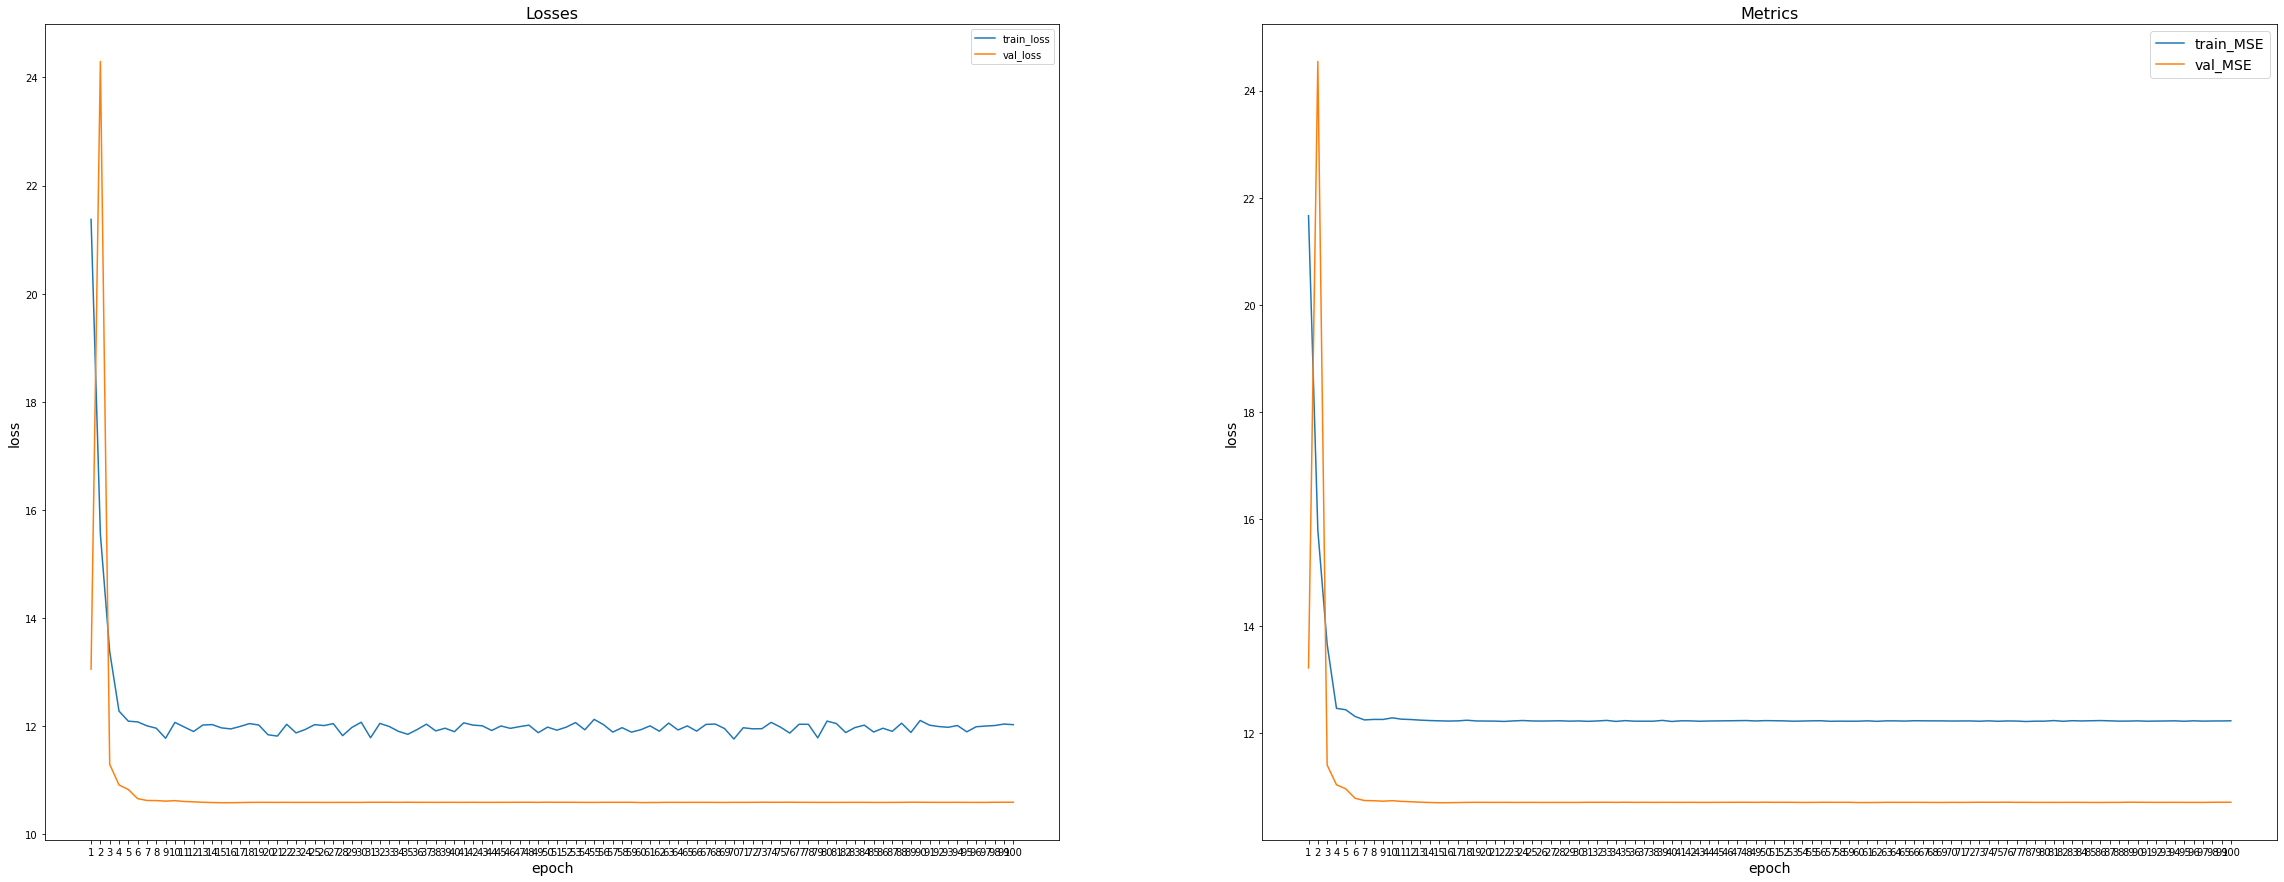

In [75]:
plot_history(history=history)

# 2) Output_size сеток с одномерным аутпутом (предполагаем независимость всех компонент силы)

Просто обучаю набор сеток на задачу регрессии, в качестве метрики для каждой сетки буду использовать MSE, а итоговая метрика - сумма MSE для каждой сетки

(Просто делаю массив из экземпляров сеток, optim-ов, loss-ов и потом циклом по ним делаю ровно тот же самый вызов history )

In [39]:
# Всем сеткам делаю абсолютно одинаковые гиперпараметры

models = [SingleNet(output_size=1) for _ in range(CFG.output_size)]

lr = 4e-3
betas=(0.9, 0.999)
weight_decay=0.1

optims = [optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay) for model in models]

step_size = 5
gamma = 0.1

exp_schedulers = [lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) for optimizer in optims]

criterion = nn.MSELoss()

In [40]:
from collections import defaultdict

Самое главное при обучении этих моделей - то что у model[ i ] - таргет - это число force[ i ]

In [41]:
def train_models():
    '''
    
    Возвращает словарь из history для всех моделей: {1: history, 2: history, ...}

    '''

    histories = defaultdict(list)

    # Надо менять немного цикл обучения, чтобы таргетом для i сетки была i-ая компонента вектора силы

    # for i in range(CFG.output_size):
    #     histories[str(i)] = train(
    #         train_loader=train_loader,
    #         val_loader=val_loader,
    #         model=model,
    #         optimizer=optimizer,
    #         scheduler=exp_scheduler,
    #         criterion=nn.MSELoss(),
    #         epochs=10
    #     )

# 3) GPR модель 
    - (потом можно сюда навалить и сетку в качестве ядра и вообще deep GP юзать, плюс еще feature extractor в виде сверток юзать сначала, если очень большая матрица, но сначала надо обычный сделать)

## 3.1) Не стохастический подход

https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html - как обучать модели в gpytorch

https://docs.gpytorch.ai/en/v1.3.1/examples/04_Variational_and_Approximate_GPs/SVGP_Regression_CUDA.html - как обучать GP по мини батчам, когда данных слишком много

У авторов $C_{mn}$ - это матрица ковариации по всему датасету, а $d_{mn}$ - некоторое введенное расстояние между матрицами, чтобы мы могли использовать экспоненциальное ядро, короче нам надо какое-то ядро, которое две матрицы, а не два числа принимает

- Весьма убедительно считать расстояние между матрицами просто как l2 метрику между точками в NxN мерном пространстве

Короче надо GPR сделать, у которого точки - матрицы и прогнозируется векторная величина, то есть для матрицы $x_*$ из инпута мы должны получать: $\mu_* = E[f(x_*)]$ - трехмерное мат ожидание для предсказания и $S$

In [42]:
import gpytorch

- В предположении что компоненты силы независимы, можно использовать Batch Independent Multioutput GP, предсказывая [fx, fy, fz]

- Если предсказывать k проекций на все V_i, то компоненты уже зависимые и надо это учитывать и использовать другую модель: MultitaskGPModel

лосс делаем -mll: минус логарифм правдоподобия: $-log[p(output Y | test X)]$

In [61]:
train_X = torch.stack([elem[0] for elem in train_data])
train_Y = torch.stack([elem[1] for elem in train_data])

val_X = torch.stack([elem[0] for elem in val_data])
val_Y = torch.stack([elem[1] for elem in val_data])

**Про свертки и когда они ожидаемо будут и не будут работать:**

    - если мы используем обычный GP, то мы обязаны каждый шаг обучаться на всем train_X - так алгоритм работает, поэтому и сверточная сеть так же должна будет обучаться, по-сути с батч_сайз = дата_сайз, но оно так вычислительно неподъемно или просто не успеет за такое маленькое количество шагов обучиться

    - Поэтому стоит использовать алгоритм Stochastic Variational GP Regression, который подразумевает совместимость с torch.DataLoader, когда данных будет очень много, там используется стохастический алгоритм, позволяющий на батче обновлять параметры

In [113]:
class IndependentOutputsMultitaskGPModel(gpytorch.models.ExactGP):
    '''

    Class for multi output GPregression with independent components of output,
    formally we are training output_size GP models

    feature_extractor: torch network that consists only of convolutions (fully convolutional net)

    '''
    def __init__(self, train_x, train_y, likelihood, output_size=3, feature_extractor=None):
        super().__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([output_size]))     # batch_shape позволяет нам для каждой модели отдельные параметры сделать
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([output_size])),
        )

        self.feature_extractor = feature_extractor
        self.output_size = output_size

    def forward(self, x):
        if self.feature_extractor:
            convoluted_x = self.feature_extractor(x)
            convoluted_n_flattened_x = convoluted_x.view(convoluted_x.size(0), -1)  # flattening
        else:
            convoluted_n_flattened_x = x.view(x.size(0), -1)    # flattening

        mean_x = self.mean_module(convoluted_n_flattened_x)
        covar_x = self.covar_module(convoluted_n_flattened_x)

        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

In [85]:
class MinusLogLikelihoodLoss:
    def __init__(self, likelihood, model):
        self.mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    def __call__(self, model_output, true_target):
        '''

        model_output: what model(train_x) returns, mll uses likelihood by itself

        returns -mll(output, target)

        '''
        return -self.mll(model_output, true_target)

In [111]:
def GP_train(likelihood, model, optimizer, loss_obj, training_iterations: int, train_X, train_Y):
    '''

    loss_obj should be an object of a class, which has __call__ method

    to have a clear perspective: on a stochastic network training I used around 2500 iterations

    returns history of MSE and loss

    '''
    model.train()
    likelihood.train()

    history = defaultdict(list)

    # scaler = amp.GradScaler()
    
    # Здесь нам не надо running_loss и running_MSE, потому что подаем сразу весь датасета в типе non-stochastic GP

    # Здесь реально обучаются параметры GPR, поскольку некоторая параметрическая часть у GPR все-таки присутствует
    for i in range(training_iterations):
        optimizer.zero_grad()

        output = model(train_X)

        loss = loss_obj(output, train_Y)
        loss.backward()

        predictions = likelihood(model(train_X))
        mean = predictions.mean
        lower, upper = predictions.confidence_region()

        train_MSE = F.mse_loss(input=mean, target=train_Y, reduction='mean').item()

        print(f'Iter: {i + 1}, train_MSE = {train_MSE}, train_loss = {loss}') if i % 10 == 0 else 1

        optimizer.step()

        history['MSE'].append(train_MSE)
        history['loss'].append(loss)

    return history

Можно еще в процессе обучения параметров периодически смотреть на качество на валидационной выборке

In [110]:
def GP_eval(likelihood, model, optimizer, loss_obj, val_X, val_Y):
    '''
    


    '''
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        output = model(val_X)
        loss = loss_obj(output, val_Y)

    predictions = likelihood(model(val_X))

    mean = predictions.mean
    lower, upper = predictions.confidence_region()

    val_MSE = F.mse_loss(input=mean, target=val_Y, reduction='mean').item()

    print(f'val_MSE = {val_MSE}, val_loss = {loss}')

    return mean, lower, upper

In [115]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)
model = IndependentOutputsMultitaskGPModel(train_X, train_Y, likelihood)

if likelihood.num_tasks != model.output_size:
    raise Exception('Different output dimensions for model and likelihood')

optimizer = torch.optim.Adam(model.parameters(), lr=0.1 weight_decay=0.03)

loss_obj = MinusLogLikelihoodLoss(likelihood=likelihood, model=model)

In [116]:
GP_train(
    likelihood=likelihood,
    model=model,
    optimizer=optimizer,
    loss_obj=loss_obj,
    training_iterations=1000,
    train_X=train_X,
    train_Y=train_Y
)

/home/alphonse/anaconda3/envs/myenv/lib/python3.8/site-packages/gpytorch/functions/_pivoted_cholesky.py:114: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  [L, torch.triangular_solve(Krows[..., m:, :].transpose(-1, -2), L, upper=False)[0].transpose(-1, -2)],


Iter: 1, train_MSE = 4.1159186363220215, train_loss = 2.456655740737915
Iter: 11, train_MSE = 4.116028308868408, train_loss = 2.454908847808838
Iter: 21, train_MSE = 4.116152763366699, train_loss = 2.452437400817871
Iter: 31, train_MSE = 4.1162872314453125, train_loss = 2.4500389099121094
Iter: 41, train_MSE = 4.116424560546875, train_loss = 2.4459784030914307
Iter: 51, train_MSE = 4.116559028625488, train_loss = 2.44787335395813
Iter: 61, train_MSE = 4.1166863441467285, train_loss = 2.44366717338562
Iter: 71, train_MSE = 4.116801738739014, train_loss = 2.4404027462005615
Iter: 81, train_MSE = 4.1168999671936035, train_loss = 2.4388680458068848
Iter: 91, train_MSE = 4.11698055267334, train_loss = 2.4373786449432373
Iter: 101, train_MSE = 4.117045879364014, train_loss = 2.4357588291168213
Iter: 111, train_MSE = 4.117096900939941, train_loss = 2.434495210647583
Iter: 121, train_MSE = 4.117136001586914, train_loss = 2.429875373840332
Iter: 131, train_MSE = 4.117166519165039, train_loss = 

: 

: 

---

# Пока мои выводы / результаты: 

- Про сетки:
    - Поскольку в датасете огромное количество сил очень маленькие - модель не в состоянии научиться определять болшьие силы, надо какой-то кастомный лосс придумывать, учитывающий это

    - Пока по какой-то причине сетка просто выдает одинаковый аутпут на весь батч на большом количестве частиц (и со свертками и без, и при большом и при маленьком K)

    - Для 2 частиц с K = 2 на одной сетке получилось val_MSE = 0.75

    - Для 50 частиц с K = 25 вообще ничего не вышло, с K = 5 пока тоже

Поэтому я пока отложу идею с 3 сетками и попробую покрутить GPR